### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import subjects
from plotters import violinplot
import pandas as pd
import seaborn as sns
from neuropy.plotting import Fig
from scipy import stats
from subjects import stat_kw
from neuropy import plotting
from statannotations.Annotator import Annotator

grpdata = subjects.GroupData()

# wcorr_df= grpdata.replay_wcorr
# radon_df= grpdata.replay_radon
# jump_df= grpdata.replay_jumpdist

wcorr_df = grpdata.replay_wcorr_mua
radon_df = grpdata.replay_radon_mua
jump_df = grpdata.replay_jumpdist_mua

assert len(wcorr_df) == len(radon_df) == len(jump_df)

### Individual sessions
- plotting wcorr and radon distribution

In [ ]:
fig = Fig(grid=(8, 5), width_ratios=[2, 6, 2, 6, 1], constrained_layout=True)

sessions = subjects.pf_sess()

cols = ["zt", "score", "method", "session", "name", "grp"]
replay_df = pd.concat([wcorr_df[cols], radon_df[cols], jump_df[cols]])

for g, grp in enumerate(["NSD", "SD"]):
    grp_df = replay_df[replay_df.grp == grp]
    sessions_id = grp_df.session.unique()

    for s, sess_id in enumerate(sessions_id):
        sess_df = grp_df[grp_df.session == sess_id]
        name = sess_df.name.unique()[0]

        # gs_ = fig.subplot2grid(fig.gs[s, 2 * g + 1],(2,1),height_ratios=[3,7],hspace=0)
        ax = fig.subplot(fig.gs[s, 2 * g + 1])
        # ax = fig.subplot(gs_[1])
        palette = [subjects.colors_sd(_)[g] for _ in np.ones(5)]
        plot_kw = dict(
            data=sess_df,
            x="method",
            y="score",
            hue="zt",
            hue_order=["PRE", "MAZE", "0-2.5", "2.5-5", "5-7.5"],
            ax=ax,
        )
        sns.violinplot(
            **plot_kw, palette=palette, inner=None, linewidth=0.5, saturation=1
        )
        sns.pointplot(
            **plot_kw, ci=None, palette=["w", "w"], join=False, scale=0.25, dodge=0.6
        )
        # ax.axhline(1,color='#2fd077')
        ax.set_ylim(-0.2, 1.7)
        # ax.set_ylim(0,1.2)
        ax.set_xlabel("")
        ax.legend("", frameon=False)

        orders = sess_df.method.unique()
        zts = sess_df.zt.unique()[1:]

        pairs = []
        pvalues = []
        for m in ["wcorr", "radon", "jump"]:
            x = sess_df[(sess_df.method == m) & (sess_df.zt == "PRE")].score.values
            for zt in zts:
                y = sess_df[(sess_df.method == m) & (sess_df.zt == zt)].score.values

                p = stats.mannwhitneyu(x, y, alternative="two-sided", nan_policy="omit")
                # if m == 'jump':
                #     p = stats.ranksums(x,y,'greater',nan_policy='omit')
                # else:
                #     p = stats.ranksums(x,y,'less',nan_policy='omit')

                pairs.extend([((m, "PRE"), (m, zt))])
                pvalues.append(p.pvalue)

            x = sess_df[(sess_df.method == m) & (sess_df.zt == "2.5-5")].score.values
            y = sess_df[(sess_df.method == m) & (sess_df.zt == "5-7.5")].score.values
            p = stats.mannwhitneyu(x, y, alternative="two-sided", nan_policy="omit")

            pairs.extend([((m, "2.5-5"), (m, "5-7.5"))])
            pvalues.append(p.pvalue)

        # ax = fig.subplot(gs_[0])
        ax = ax.inset_axes([0, 0.8, 1, 0.3])
        plot_kw["ax"] = ax
        annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
        stat_kw["loc"] = "inside"
        stat_kw["text_offset"] = 0.02
        stat_kw["verbose"] = False
        # del stat_kw['line_offset_to_group']
        # del stat_kw['line_offset']
        annotator.configure(**stat_kw)
        annotator.set_pvalues(pvalues)
        annotator.annotate(line_offset_to_group=0.1, line_offset=0.1)
        annotator.reset_configuration()
        ax.set_axis_off()

        ax = fig.subplot(fig.gs[s, 2 * g])
        sess_ = sessions[sess_id]
        maze = sess_.paradigm["maze"].flatten()
        position = sess_.position.time_slice(*maze)
        ax.plot(position.x, position.y, color="#1cca56", lw=0.5)
        ax.axis("off")
        ax.set_title(name, loc="left")

# fig.savefig(subjects.figpath_sd/'replay_measures_using_mua_manwhitney')

### Plot proportion of events which are 95 percentile above PRE

In [ ]:
radon_df.speed > 100

In [ ]:
_, ax = plt.subplots()

# reject_sessions = wcorr_df.name.isin(['RatKDay2','RatKDay1','RatRDay2','RatVDay2','RatVDay3','RatUDay1'])

wcorr_bool = wcorr_df.perc_rel_pre >= 95
radon_bool = (radon_df.perc_rel_pre >= 95) & (radon_df.speed > 100)
jump_bool = jump_df.perc_rel_pre <= 5

bool_indx = jump_bool & radon_bool
total_events = radon_df.groupby(["grp", "session", "zt"], sort=False).count()
good_events = radon_df[bool_indx].groupby(["grp", "session", "zt"], sort=False).count()
prop = (good_events / total_events).reset_index()

prop = prop[prop.zt != "MAZE"]
sns.stripplot(data=prop, x="zt", y="score", hue="grp", dodge=True)

### Plot pooled distributions

In [ ]:
fig = plotting.Fig(grid=(6, 4), fontsize=7)

# sns.violinplot(data=wcorr_df,x='zt',y='score',hue='grp',split=True)
# df = radon_df[~radon_df.name.isin(['RatUDay2'])]
# df = radon_df[radon_df.n_neurons>=80]
# df = radon_df[radon_df.speed>=00]

ax = fig.subplot(fig.gs[0])
plot_kw = dict(
    data=radon_df, x="zt", y="score", hue="grp", hue_order=["NSD", "SD"], ax=ax
)
violinplot(**plot_kw)
orders = radon_df.zt.unique()

# Within groups
for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [(("0-2.5", g), ("5-7.5", g)), (("2.5-5", g), ("5-7.5", g))]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(test="Kruskal", **stat_kw, color=subjects.colors_sd(1)[i])
    annotator.apply_and_annotate()
    # annotator.apply_test().annotate(line_offset_to_group=k)
    annotator.reset_configuration()


ax = fig.subplot(fig.gs[1])
plot_kw = dict(
    data=radon_df, x="zt", y="score_rel_pre", hue="grp", hue_order=["NSD", "SD"], ax=ax
)
violinplot(**plot_kw)
orders = radon_df.zt.unique()

# Within groups
for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [(("0-2.5", g), ("5-7.5", g)), (("2.5-5", g), ("5-7.5", g))]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(test="Kruskal", **stat_kw, color=subjects.colors_sd(1)[i])
    annotator.apply_and_annotate()
    # annotator.apply_test().annotate(line_offset_to_group=k)
    annotator.reset_configuration()

# fig.savefig(subjects.figpath_sd/'radon_dist_stat')

### Plot mean radon score of each session and compare between NSD vs SD

/tmp/ipykernel_3178356/2570961055.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = radon_df.groupby(["grp", "session", "zt"], sort=False).mean().reset_index()
/tmp/ipykernel_3178356/2570961055.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MAZE_NSD vs. MAZE_SD: Welch's t-test independent samples, P_val:4.505e-01 t=7.874e-01
PRE_NSD vs. PRE_SD: Welch's t-test independent samples, P_val:2.058e-01 t=1.351e+00
0-2.5_NSD vs. 0-2.5_SD: Welch's t-test independent samples, P_val:2.531e-01 t=1.220e+00
2.5-5_NSD vs. 2.5-5_SD: Welch's t-test independent samples, P_val:3.198e-01 t=1.069e+00
5-7.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:4.113e-01 t=8.704e-01
0-2.5_NSD vs. 5-7.5_SD: Welch's t-test independent samples, P_val:2.902e-01 t=1.134e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2.5-5_NSD vs. 5-7.5_NSD: Welch's t-test independent samples, P_val:9.261e-01 t=9.508e-02
0-2.5_NSD vs. 5-7.5_NSD: We

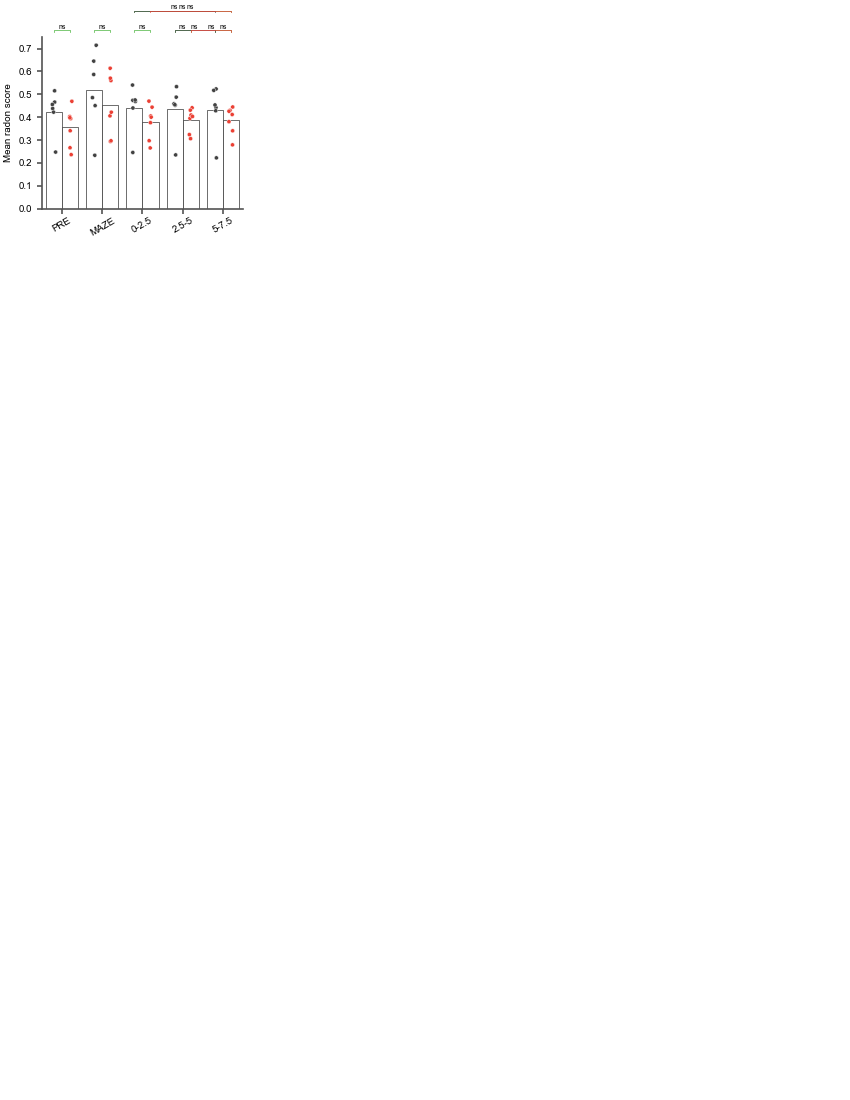

In [3]:
fig = plotting.Fig(grid=(6, 4), fontsize=7)

# sns.violinplot(data=wcorr_df,x='zt',y='score',hue='grp',split=True)
# df = radon_df[~radon_df.name.isin(['RatUDay2'])]
# df = radon_df[radon_df.n_neurons>=80]
# df = radon_df[radon_df.speed>=00]

ax = fig.subplot(fig.gs[0])
df = radon_df.groupby(["grp", "session", "zt"], sort=False).mean().reset_index()
plot_kw = dict(data=df, x="zt", y="score", hue="grp", hue_order=["NSD", "SD"], ax=ax)

sns.stripplot(
    **plot_kw,
    palette=subjects.colors_sd(),
    edgecolor="w",
    linewidth=0.3,
    size=3,
    dodge=True,
)
sns.barplot(
    **plot_kw,
    palette=subjects.colors_sd(1),
    ci=None,
    facecolor="w",
    linewidth=0.5,
    edgecolor=".2",
)
ax.tick_params("x", labelrotation=30)
ax.legend([], frameon=False)
ax.set_ylabel("Mean radon score")
ax.set_xlabel("")

orders = radon_df.zt.unique()

pairs = [((_, "NSD"), (_, "SD")) for _ in orders] + [
    (("0-2.5", "NSD"), ("5-7.5", "SD"))
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **stat_kw, color="#4AB33E")
annotator.apply_and_annotate()
annotator.reset_configuration()


# Within groups
for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [(("0-2.5", g), ("5-7.5", g)), (("2.5-5", g), ("5-7.5", g))]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(test="t-test_welch", **stat_kw, color=subjects.colors_sd(1)[i])
    annotator.apply_and_annotate()
    # annotator.apply_test().annotate(line_offset_to_group=k)
    annotator.reset_configuration()


# ax = fig.subplot(fig.gs[1])
# plot_kw = dict(
#     data=radon_df, x="zt", y="score_rel_pre", hue="grp", hue_order=["NSD", "SD"], ax=ax
# )
# violinplot(**plot_kw)
# orders = radon_df.zt.unique()

# # Within groups
# for i, g in enumerate(["NSD", "SD"]):
#     pairs2 = [(("0-2.5", g), ("5-7.5", g)), (("2.5-5", g), ("5-7.5", g))]
#     annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
#     annotator.configure(test="Kruskal", **stat_kw, color=subjects.colors_sd(1)[i])
#     annotator.apply_and_annotate()
#     # annotator.apply_test().annotate(line_offset_to_group=k)
#     annotator.reset_configuration()

# fig.savefig(subjects.figpath_sd/'mean_radon_score_individual_sessions')

### Plot mean radon score of each session and normalize by PRE (NSD vs SD)

In [ ]:
fig = plotting.Fig(grid=(6, 4), fontsize=7)

# sns.violinplot(data=wcorr_df,x='zt',y='score',hue='grp',split=True)
# df = radon_df[~radon_df.name.isin(['RatUDay2'])]
# df = radon_df[radon_df.n_neurons>=80]
# df = radon_df[radon_df.speed>=00]

mean_df = radon_df.groupby(["grp", "session", "zt"], sort=False).mean().reset_index()

sess_inds = mean_df["session"].unique()

new_df = []
for i, sess_ind in enumerate(sess_inds):
    sess_df = mean_df[(mean_df.session == sess_ind)]
    pre_val = sess_df[(sess_df.zt == "PRE")].score.values
    sess_df["norm_score"] = sess_df["score"] / pre_val
    new_df.append(sess_df)

new_df = pd.concat(new_df, ignore_index=True)


ax = fig.subplot(fig.gs[0])
plot_kw = dict(
    data=new_df, x="zt", y="norm_score", hue="grp", hue_order=["NSD", "SD"], ax=ax
)

sns.stripplot(
    **plot_kw,
    palette=subjects.colors_sd(),
    edgecolor="w",
    linewidth=0.3,
    size=3,
    dodge=True,
)
sns.barplot(
    **plot_kw,
    palette=subjects.colors_sd(1),
    ci=None,
    facecolor="w",
    linewidth=0.5,
    edgecolor=".2",
)
ax.tick_params("x", labelrotation=30)
ax.legend([], frameon=False)
ax.set_ylabel("Radon score (normalized by PRE)")
ax.set_xlabel("")

orders = radon_df.zt.unique()

pairs = [((_, "NSD"), (_, "SD")) for _ in orders] + [
    (("0-2.5", "NSD"), ("5-7.5", "SD"))
]
annotator = Annotator(pairs=pairs, **plot_kw, order=orders)
annotator.configure(test="t-test_welch", **stat_kw, color="#4AB33E")
annotator.apply_and_annotate()
annotator.reset_configuration()


# Within groups
for i, g in enumerate(["NSD", "SD"]):
    pairs2 = [(("0-2.5", g), ("5-7.5", g)), (("2.5-5", g), ("5-7.5", g))]
    annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
    annotator.configure(test="t-test_welch", **stat_kw, color=subjects.colors_sd(1)[i])
    annotator.apply_and_annotate()
    # annotator.apply_test().annotate(line_offset_to_group=k)
    annotator.reset_configuration()


# ax = fig.subplot(fig.gs[1])
# plot_kw = dict(
#     data=radon_df, x="zt", y="score_rel_pre", hue="grp", hue_order=["NSD", "SD"], ax=ax
# )
# violinplot(**plot_kw)
# orders = radon_df.zt.unique()

# # Within groups
# for i, g in enumerate(["NSD", "SD"]):
#     pairs2 = [(("0-2.5", g), ("5-7.5", g)), (("2.5-5", g), ("5-7.5", g))]
#     annotator = Annotator(pairs=pairs2, **plot_kw, order=orders)
#     annotator.configure(test="Kruskal", **stat_kw, color=subjects.colors_sd(1)[i])
#     annotator.apply_and_annotate()
#     # annotator.apply_test().annotate(line_offset_to_group=k)
#     annotator.reset_configuration()

fig.savefig(subjects.figpath_sd / "norm_radon_score_individual_sessions")

### Radon score vs speed NSD vs SD

In [ ]:
sessions = subjects.pf_sess()

radon_df = []
for sub, sess in enumerate(sessions):
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pbe_epochs = sess.pbe.flatten()
    pbe = sess.pbe.to_dataframe()
    pbe_peak = pbe.peak_time
    replay_pbe = sess.replay_radon.to_dataframe()

    starts = replay_pbe.start.values

    up_score = replay_pbe.up_radon_score.values
    up_vel = replay_pbe.up_velocity.values
    down_score = replay_pbe.down_radon_score.values
    down_vel = replay_pbe.down_velocity.values

    best_bool = up_score > down_score
    score = np.zeros(len(starts))
    score[best_bool] = up_score[best_bool]
    score[~best_bool] = down_score[~best_bool]
    # score = stats.zscore(score)

    vel = np.zeros(len(starts))
    vel[best_bool] = up_vel[best_bool]
    vel[~best_bool] = down_vel[~best_bool]

    # score = np.maximum(up_vel,down_vel)

    epochs = sess.get_zt_epochs(include_maze=True)

    period = epochs["PRE"].flatten()
    period_indx = (starts > period[0]) & (starts < period[1])
    mean_period = score[period_indx].mean()

    for i, e in enumerate(epochs.itertuples()):
        indx = (starts > e.start) & (starts < e.stop)
        vel_e = vel[indx]
        vel_bool = np.abs(vel_e) < 5000
        score_e = score[indx]
        radon_df.append(
            pd.DataFrame(
                {
                    "zt": e.label,
                    "score": score_e[vel_bool],
                    "vel": vel_e[vel_bool],
                    "session": sub,
                    "grp": sess.tag,
                }
            )
        )

radon_df = pd.concat(radon_df, ignore_index=True)

subfig = fig.fig.add_subfigure(fig.gs[2:4, :4])
axs = subfig.subplots(2, 5, sharex=True, sharey=True)

zts = radon_df.zt.unique()
for i, zt in enumerate(zts):
    for g, grp in enumerate(["NSD", "SD"]):
        ax = axs[g, i]
        df = radon_df[(radon_df.zt == zt) & (radon_df.grp == grp)]
        ax.scatter(df.vel, df.score, s=1, c=subjects.colors_sd()[g], rasterized=True)
        # ax.axvline(-100)
        # ax.axvline(100)
        # ax.set_xscale('log')

In [ ]:
fig.savefig(subjects.figpath_sd / "replay_figures")